### Multivariate CCA

This notebook verifies the concept of the initialization method of the operator A 
(1) input: multivariate data (funcitonal score)
(2) verifies the algorithm in the population domain (not empirical estimate)

In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#generate A
def gen_ortho(k,km, n_block, scale):
    w = int(km / n_block)
    h = int(k / n_block)
    A = np.zeros((k,km))
    for bk in range(n_block):
        if(bk != n_block-1):
            m = np.random.normal(0,1,(h, w))
            if k <= km:
                m, _ = np.linalg.qr(m.T)
                m = m.T
            else:
                m, _ = np.linalg.qr(m)
            row_norm = np.linalg.norm(m,axis=1)

            A[bk*h:(bk+1)*h, bk*w:(bk+1)*w] = np.diag(scale*row_norm) @ m 
        else:
            m = np.random.normal(0,1,(k-bk*h, km-bk*w))
            if m.shape[0] <= m.shape[1]:
                m, _ = np.linalg.qr(m.T)
                m = m.T
            else:
                m, _ = np.linalg.qr(m)
            row_norm = np.linalg.norm(m,axis=1)
            A[bk*h::, bk*w::] =  np.diag(scale*row_norm) @ m   

    return A     


In [4]:
k = 10
km = 10
Q = np.diag(.2*np.arange(k) + 1)
A1 = Q @ gen_ortho(k, km, 7, .2) 
A2 = Q @ gen_ortho(k, km, 5, .1)
invA1 = np.linalg.solve(A1, np.eye(km))
invA2 = np.linalg.solve(A2, np.eye(km))
#invA1 = np.linalg.pinv(A1)
#invA2 = np.linalg.pinv(A2)
np.diag(0.1*(np.arange(k)+1))

#generate noise matrix
N1 = gen_ortho(k, km, 7, 1) 
N1 = (N1 @N1.T) * .5 + np.eye(k)*.5
N2 = gen_ortho(k, km, 5, 1) 
N2 = (N2 @ N2.T) * .5 + np.eye(k)*.5
cov1 = invA1 @ invA1.T + N1#np.diag(0.1*(np.arange(k)+1)) #

eig1, _ = np.linalg.eigh(invA1 @ invA1.T )
eig1_n,_ = np.linalg.eigh(cov1)

cov2 = invA2 @ invA2.T + N2#np.diag(0.1*(np.arange(k)+1)) #np.diag(.2*np.arange(15) + 1)

eig2, _ = np.linalg.eigh(invA2 @ invA2.T )
eig2_n,_ = np.linalg.eigh(cov2)

"""
plt.plot(np.arange(k)+1, eig1_n, label="noise 1")
plt.plot(np.arange(k)+1, eig2_n, label="noise 2")

plt.plot(np.arange(k)+1, eig1, label="A1")
plt.plot(np.arange(k)+1, eig2, label="A2")
plt.legend()
plt.show()
lambda_n1 = np.linalg.eigvals(N1)

lambda_n2 = np.linalg.eigvals(N2)

plt.plot(np.arange(k)+1, lambda_n1, label="noise 1")
plt.plot(np.arange(k)+1, lambda_n2, label="noise 2")

lambda_a1 = np.linalg.eigvals(invA1 @ invA1.T)
lambda_a2 = np.linalg.eigvals(invA2 @ invA2.T)

plt.plot(np.arange(k)+1, lambda_a1, label="A1")
plt.plot(np.arange(k)+1, lambda_a2, label="A2")

plt.legend()
plt.show()
"""
cov12 = invA1 @ invA2.T

v, u = np.linalg.eigh(cov1)
invh_cov1 = u @ np.diag(1./(np.sqrt(v))) @ u.T

v, u = np.linalg.eigh(cov2)
invh_cov2 = u @ np.diag(1./(np.sqrt(v))) @ u.T


#sample data from multivariate Gaussian
n = 50
x = np.random.multivariate_normal(np.zeros(km),cov1, n)
y = np.random.multivariate_normal(np.zeros(km),cov2, n)



### Compute A1 and A2 from CCA (population)

[1.19020428 1.16459394 1.14073268 1.11864661 1.09836242 1.07990696
 1.06330684 1.04858793 1.0357748  1.02489024]


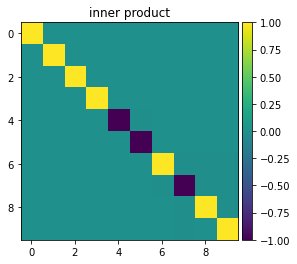

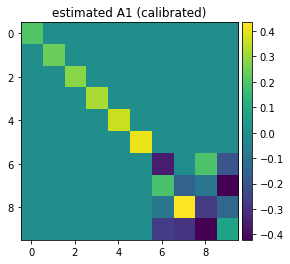

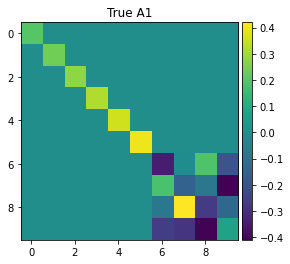

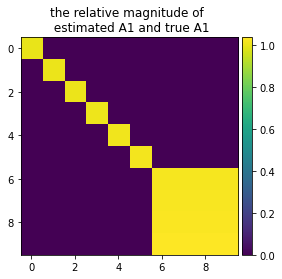

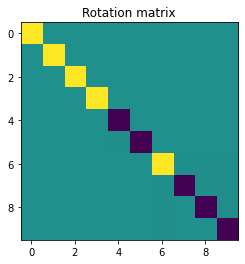

In [6]:


P = (invh_cov1 @ cov12) @ invh_cov2


v, u = np.linalg.eigh(invA1 @ invA1.T)
invh_A1 = u @ np.diag(1./(np.sqrt(v)+1e-5)) @ u.T

v, u = np.linalg.eigh(invA2 @ invA2.T)
invh_A2 = u @ np.diag(1./(np.sqrt(v)+1e-5)) @ u.T

P2 = (invh_A1 @ cov12) @ invh_A2 



P = (invh_cov1 @ cov12) @ (invh_cov2 @ invh_cov2) @ (cov12.T @ invh_cov1)






v,u = np.linalg.eigh(P)

print(1/np.sqrt(v))

est_A1 = invh_cov1 @ u[:,::-1] @ np.diag(1./ np.sqrt(v[::-1]))
est_A2 = invh_cov2 @ invh_cov2 @ cov12.T @ est_A1 #@ np.diag(1./ np.sqrt(v[::-1]))

#est_A1 = invh_cov1 @ u[:,::-1] @ np.diag(1./ np.sqrt(v[::-1]))


est_A1 = est_A1.T
tempR = np.einsum("ij,kj->ik", A1, est_A1)
q,s,vh = np.linalg.svd(tempR)
R = np.einsum("ij,jk->ik",q,vh)

"""
plt.imshow(u[:,::-1])
plt.show()

a,b,c = np.linalg.svd(A1)
plt.imshow(c.T[:,::-1])
plt.show()
"""

#plt.imshow(np.abs(u[:,::-1]/(c.T[:,::-1]+1e-12)))
#plt.show()


ax = plt.subplot()
im = ax.imshow((u[:,::-1]).T @ (c.T[:,::-1]))


plt.title("inner product")
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()
ax = plt.subplot()
im = ax.imshow(( R@ est_A1))
plt.title("estimated A1 (calibrated)")
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()




ax = plt.subplot()
im = ax.imshow((A1))
plt.title("True A1")
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()


ax = plt.subplot()
im = ax.imshow(np.abs(R @ est_A1) / (np.abs(A1)+1e-10))


plt.title("the relative magnitude of \n estimated A1 and true A1")
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()


est_rownorm = np.linalg.norm((R@est_A1), axis=0)
true_rownorm = np.linalg.norm(A1, axis=0)


plt.imshow(R)
plt.title("Rotation matrix")

plt.show()

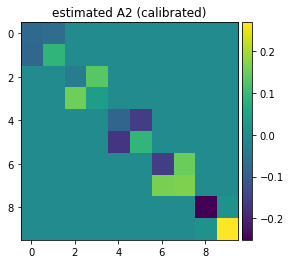

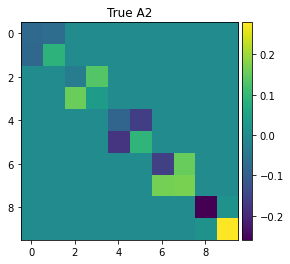

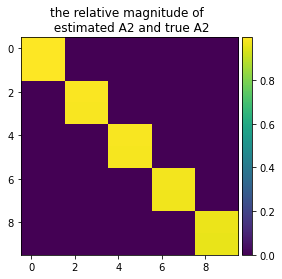

In [8]:
ax = plt.subplot()
im = ax.imshow(R @ est_A2.T)
plt.title("estimated A2 (calibrated)")
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()




ax = plt.subplot()
im = ax.imshow(A2)
plt.title("True A2")
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()




ax = plt.subplot()
im = ax.imshow(np.abs((R @ est_A2.T) / (A2+1e-5)))
plt.title("the relative magnitude of \n estimated A2 and true A2")
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.show()

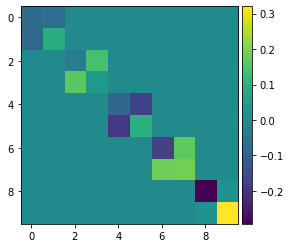

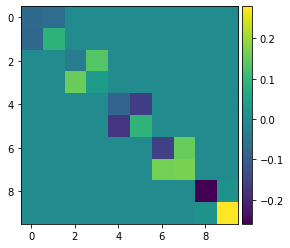

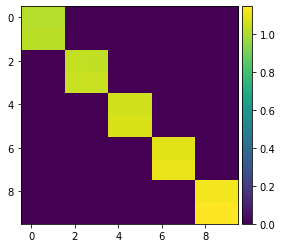

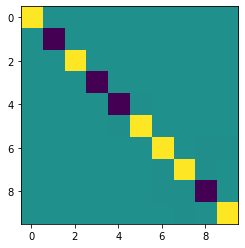

In [9]:
#try the inverse eigenvector 

P = (invh_cov2 @ cov12.T) @ (invh_cov1 @ invh_cov1) @ (cov12 @ invh_cov2)
v,u = np.linalg.eigh(P)

est_A2 = invh_cov2 @ u[:,::-1] @ np.diag(1./np.sqrt(v[::-1]))

est_A2 = est_A2.T
tempR = np.einsum("ij,kj->ik", A2, est_A2)
u,s,vh = np.linalg.svd(tempR)
R = np.einsum("ij,jk->ik",u,vh)


ax = plt.subplot()
im = ax.imshow( R@ est_A2)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()




ax = plt.subplot()
im = ax.imshow(A2)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()



ax = plt.subplot()
im = ax.imshow( (R @ est_A2) / (A2+1e-5))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.show()

plt.imshow(R)
plt.show()